# Attention Is All You Need Paper Tutorial

In [1]:
import random
import math
from IPython.display import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from torch.nn.utils.rnn import pad_sequence

from datasets import load_dataset

from tokenizers import Tokenizer
from tokenizers.processors import TemplateProcessing
from tokenizers import normalizers
from tokenizers.normalizers import Lowercase, NFD, StripAccents
from tokenizers.trainers import BpeTrainer, WordLevelTrainer
from tokenizers.models import WordLevel, BPE
from tokenizers.pre_tokenizers import Whitespace,WhitespaceSplit

# Configuration

In [2]:
config=dict(
    # RUN CONFIG:
    RUN_NAME='unofficial_single_gpu_run',
    RUN_DESCRIPTION='No description',
    RUNS_FOLDER_PTH='../runs',
    # DATA CONFIG:
    DATASET_SIZE=30000, # WARN: This is too small but makes it easy to go through the notebook fast
    TEST_PROPORTION=0.01,
    MAX_SEQ_LEN=40,
    VOCAB_SIZE=60000,
    TOKENIZER_TYPE='wordlevel',
    # TRAINING CONFIG:
    BATCH_SIZE=48, 
    GRAD_ACCUMULATION_STEPS=2048//48,
    WORKER_COUNT=10,
    EPOCHS=100,
    # OPTIMIZER CONFIG:
    BETAS=(0.9, 0.98),
    EPS=1e-9,
    # SCHEDULER CONFIG:
    N_WARMUP_STEPS=4000, 
    # MODEL CONFIG:
    D_MODEL=512,
    N_BLOCKS=6,
    N_HEADS=8,
    D_FF=2048,
    DROPOUT_PROBA=0.1,
    # OTHER:
    MODEL_SAVE_EPOCH_CNT=10,
    DEVICE='gpu',
    LABEL_SMOOTHING=0.1,
)

# Dataset & Preprocessing

Authors of the paper used the WMT 2014 English-German dataset consisting of 4.5 million sentence pairs, same is used here.

## Load dataset

 For loading the dataset we will use the HuggingFace Datasets library which will help us download and generally manipulate the dataset much easier. DATASET_SIZE parameter specified in config let's us select only a part of the dataset if we do not wish to train on the whole. 

In [3]:
data=load_dataset('wmt14','de-en',split='train').shuffle(seed=42)
data=data.select(range(config['DATASET_SIZE'])) 
data=data.flatten()
data=data.rename_column('translation.de','translation_trg')
data=data.rename_column('translation.en','translation_src')

Reusing dataset wmt14 (C:\Users\bkoch\.cache\huggingface\datasets\wmt14\de-en\1.0.0\d239eaf0ff090d28da19b6bc9758e24634d84de0a1ef092f0b5c54e6f132d7e2)
Loading cached shuffled indices for dataset at C:\Users\bkoch\.cache\huggingface\datasets\wmt14\de-en\1.0.0\d239eaf0ff090d28da19b6bc9758e24634d84de0a1ef092f0b5c54e6f132d7e2\cache-8d69856db5e788bb.arrow


In [4]:
data[0]

{'translation_trg': 'In diesem Rubrik finden Sie Fahndungsmeldungen, die auf Anfrage eines Staatsanwalts oder Untersuchungsrichter verbreitet werden.',
 'translation_src': "On these pages you will find the wanted or missing notices that are issued at public prosecutor or examining magistrate's request."}

## Create Tokenizer

For creating the tokenizer we use the HuggingFace Tokenizers library. In the paper they used a single BPE tokenizer trained on sentences from both languages. A word level tokenizer is selected here instead, as I found that for my simpler training configurations it worked better. Also note that if choosing a word-level tokenizer the vocabulary size (VOCAB_SIZE param) needs to be increased compared to the 37000 word vocabulary for the BPE mentioned in the paper.

The process of creating a tokenizer boils down to selecting a tokenization model and customizing its components. For more info on the components I used here, see the [hugging face docs](https://huggingface.co/docs/tokenizers/python/latest/components.html)

**SPECIAL TOKENS**

[BOS], [EOS], [PAD] and [UNK] tokens are also added. [BOS] token is useful in the decoder input to signalize the beggining of a sentece, remember that the original transformer decoder predicts the next word in the sequence by looking at the encoder representation and the decoder input up to the current timestep.Therefore for predicting the first word it only sees the [BOS]. [EOS] token signalizes the end of the sequence and therefore the end of decoding when inferencing.

In [5]:
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.normalizer=normalizers.Sequence([NFD(),StripAccents(), Lowercase()])
tokenizer.pre_tokenizer = WhitespaceSplit()
trainer_src = WordLevelTrainer(vocab_size=config['VOCAB_SIZE'], special_tokens=["[PAD]", "[UNK]", "[BOS]", "[EOS]"]) 

# Configure batch iterators to train tokenizers from memory
def batch_iterator_src(batch_size=10000):
    for i in range(0, len(data), batch_size):
        yield data[i : i + batch_size]['translation_src']
    for i in range(0, len(data), batch_size):
        yield data[i : i + batch_size]['translation_trg']

# Train tokenizers
tokenizer.train_from_iterator(batch_iterator_src(), trainer=trainer_src, length=len(data))

# Configure postprocessing to add [BOS] and [EOS] tokens to trg sequence
tokenizer.post_processor = TemplateProcessing(
    single="[BOS] $A [EOS]",
    special_tokens=[
        ("[BOS]", 2),
        ("[EOS]", 3),
    ],
)

In [6]:
# example-use
encoding=tokenizer.encode('In diesem Rubrik finden Sie Fahndungsmeldungen, die auf Anfrage eines Staatsanwalts oder Untersuchungsrichter verbreitet werden.')

print('tokens: ', encoding.tokens)
print('ids: ',encoding.ids)

tokens:  ['[BOS]', 'in', 'diesem', 'rubrik', 'finden', 'sie', 'fahndungsmeldungen,', 'die', 'auf', 'anfrage', 'eines', 'staatsanwalts', 'oder', 'untersuchungsrichter', 'verbreitet', 'werden.', '[EOS]']
ids:  [2, 5, 132, 6179, 436, 23, 1, 6, 27, 1991, 159, 52219, 63, 42162, 7194, 122, 3]


## Preprocess data

Now we tokenize the dataset. After tokenization we filter long sentences (so future batches can fit into GPU memory), perform a train/test split and sort each split by length. Sorting is done to aid batching of similar lenght sequences inside the batch sampler which speeds up training and also reduces the total count of [PAD] tokens needed.

In [7]:
def preprocess_data(data, tokenizer, max_seq_len, test_proportion):

    # Tokenize
    def tokenize(example):
        return {
            'translation_src': tokenizer.encode(example['translation_src']).ids,
            'translation_trg': tokenizer.encode(example['translation_trg']).ids,
        }
    data=data.map(tokenize)

    # Compute sequence lengths
    def sequence_length(example):
        return {
            'length_src': [len(item) for item in example['translation_src']],
            'length_trg': [len(item) for item in example['translation_trg']],
        }
    data=data.map(sequence_length, batched=True, batch_size=10000)

    # Filter by sequence lengths
    def filter_long(example):
        return example['length_src']<= max_seq_len and example['length_trg']<=max_seq_len
    data=data.filter(filter_long)

    # Split 
    data=data.train_test_split(test_size=test_proportion)

    # Sort each split by length for dynamic batching (see CustomBatchSampler)
    data['train']=data['train'].sort('length_src', reverse=True)
    data['test']=data['test'].sort('length_src', reverse=True)

    return data

In [8]:
data=preprocess_data(data, tokenizer, config['MAX_SEQ_LEN'], config['TEST_PROPORTION'])

  0%|          | 0/30000 [00:00<?, ?ex/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/30 [00:00<?, ?ba/s]

## Create PyTorch Datasets and DataLoaders

### Create Datasets

In [9]:
class TranslationDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        src_encoded=self.dataset[idx]['translation_src']
        trg_encoded=self.dataset[idx]['translation_trg']
        
        return (
            torch.tensor(src_encoded),
            torch.tensor(trg_encoded),
        )

In [10]:
train_ds=TranslationDataset(data['train'])
val_ds=TranslationDataset(data['test'])

### Create Collate function for padding sequences in a batch to same size

Collate function will pad source and target sequences in a batch to same lenght with zeros. We made sure [PAD]'s id is 0 so that's why we pad with 0 here.

We use pytorch's [pad_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) function

In [11]:
def pad_collate_fn(batch):
    src_sentences,trg_sentences=[],[]
    for sample in batch:
        src_sentences+=[sample[0]]
        trg_sentences+=[sample[1]]

    src_sentences = pad_sequence(src_sentences, batch_first=True, padding_value=0)
    trg_sentences = pad_sequence(trg_sentences, batch_first=True, padding_value=0)

    return src_sentences, trg_sentences

In [12]:
# example-use
batch=[
    (torch.tensor([1,2,3,4]),torch.tensor([1,2,3,4,5,6,7])), #x's
    (torch.tensor([1,2,3,4,5,6]), torch.tensor([1,2]))  # y's
]

pad_collate_fn(batch)

(tensor([[1, 2, 3, 4, 0, 0],
         [1, 2, 3, 4, 5, 6]]),
 tensor([[1, 2, 3, 4, 5, 6, 7],
         [1, 2, 0, 0, 0, 0, 0]]))

### Create a Batch Sampler for sampling sequences of similar lengths

Batch sampler ensures that batches contain sequences of similar lengths as explained before. It iteratively returns indices of samples that should go together in a batch. We already sorted the splits by length so here we just chunk indices of sorted elements in order. We also care to shuffle the batches here.

In [13]:
def chunk(indices, chunk_size):
    return torch.split(torch.tensor(indices), chunk_size)

class CustomBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):

        # Dataset is already sorted so just chunk indices
        # into batches of indices for sampling
        self.batch_size=batch_size
        self.indices=range(len(dataset))
        self.batch_of_indices=list(chunk(self.indices, self.batch_size))
        self.batch_of_indices = [batch.tolist() for batch in self.batch_of_indices]
    
    def __iter__(self):
        random.shuffle(self.batch_of_indices)
        return iter(self.batch_of_indices)
    
    def __len__(self):
        return len(self.batch_of_indices)

In [14]:
custom_batcher_train = CustomBatchSampler(train_ds, config['BATCH_SIZE'])
custom_batcher_val= CustomBatchSampler(val_ds, config['BATCH_SIZE'])

### Create DataLoaders

Next, Dataloaders are constructed with the described collate and batch sampling policies.

In [15]:
# example-use
dummy_batcher = CustomBatchSampler(train_ds, 3)
dummy_dl=DataLoader(train_ds, collate_fn=pad_collate_fn, batch_sampler=dummy_batcher, pin_memory=True)
for batch in dummy_dl:
    print('Shapes: ')
    print('-'*10)
    print(batch[0].size())
    print(batch[1].size())
    print()
    

    print('e.g. src batch (see there is minimal/no padding):')
    print('-'*10)
    print(batch[0].numpy())
    
    break

Shapes: 
----------
torch.Size([3, 15])
torch.Size([3, 13])

e.g. src batch (see there is minimal/no padding):
----------
[[    2 12075    21     4   439    13    12  1633   345     7  4880   537
      4  1224     3]
 [    2    38    84   186     4   547     7     4 36564 30068   338     5
     24  1755     3]
 [    2   281 49681  1655    12 38005    75    57    12   284 30704     1
     10     1     3]]


In [16]:
train_dl=DataLoader(train_ds, collate_fn=pad_collate_fn, batch_sampler=custom_batcher_train, pin_memory=True)
val_dl=DataLoader(val_ds, collate_fn=pad_collate_fn, batch_sampler=custom_batcher_val, pin_memory=True)

# Create the Transformer Architecture
For explaining the architecture I chose the bottom-up approach. First I will describe the basic building blocks and then gradually build up the transformer.

## Positional Embedding Layer

*Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence,we must inject some information about the relative or absolute position of the tokens in the sequence.*

The attention mechanism in the transformer, compared to RNN's, doesn't "contain" the concept of time in its architecture (e.g. attention doesn't care about the position of tokens in a sequence, it inheritely views it all the same, that is why it can be parallelized), therefore we have to somehow **embed the position (time-step) information into the word embeddings** inputed to the attention mechanism.

Authors solve this by **adding** (yes, just adding, not concatenating) **precomputed positional encodings to word embeddings**. Positional encodings are defined as sine and cosine functions of different frequencies

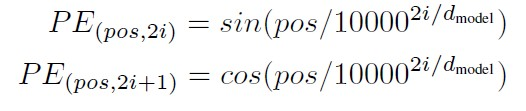

In [17]:
Image(filename='../other/positional_encoding_equation.jpg', width=400)

*Where pos is the position and i is the dimension. That is, each dimension of the positional encoding
corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000 · 2π. We
chose this function because we hypothesized it would allow the model to easily learn to attend by
relative positions, since for any fixed offset k, PEpos+k can be represented as a linear function of
PEpos.*


Also dropout is applied to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=500, dropout_proba=0.1):
        super(PositionalEncoding, self).__init__()
        self.max_seq_len=max_seq_len
        self.d_model=d_model

        pe_table=self.get_pe_table()
        self.register_buffer('pe_table' , pe_table)

        self.dropout=nn.Dropout(dropout_proba) 

    def get_pe_table(self):
        position_idxs=torch.arange(self.max_seq_len).unsqueeze(1) 
        embedding_idxs=torch.arange(self.d_model).unsqueeze(0)
        
        angle_rads = position_idxs * 1/torch.pow(10000, (2*(embedding_idxs//2))/self.d_model)

        angle_rads[:, 0::2] = torch.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = torch.cos(angle_rads[:, 1::2])

        pe_table = angle_rads.unsqueeze(0) # So we can apply it to a batch

        return pe_table

    def forward(self, embeddings_batch):
        seq_len = embeddings_batch.size(1)
        pe_batch = self.pe_table[:, :seq_len].clone().detach()
        return self.dropout(embeddings_batch + pe_batch)

To understand what is actually being added take a look at the below visualization of positional encodings.

**Each row *i* of the *pe_table* represents the vector that would be added to a word at position *i***

C:\Users\bkoch\AppData\Local\Temp/ipykernel_22780/1896077645.py:16: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  angle_rads = position_idxs * 1/torch.pow(10000, (2*(embedding_idxs//2))/self.d_model)


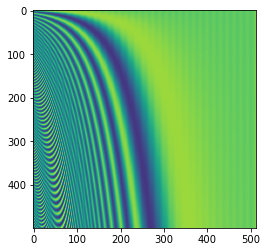

In [19]:
# example-use
import matplotlib.pyplot as plt

positional_encoding=PositionalEncoding(512, 500)
pe_table=positional_encoding.get_pe_table()

plt.imshow(pe_table.squeeze(0).numpy())

## Add & Norm Layer

Helps propagate gradients easier and speeds up learning.

In [20]:
class AddAndNorm(nn.Module):
    def __init__(self, d_model):
        super(AddAndNorm, self).__init__()
        
        self.layer_norm=nn.LayerNorm(d_model)

    def forward(self, x, residual):
        return self.layer_norm(x+residual)

## Position-wise Feed Forward layer

*In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully
connected feed-forward network, which is applied to each position separately and identically. This
consists of two linear transformations with a ReLU activation in between.*

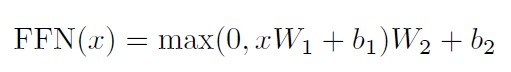

In [21]:
Image(filename='../other/feed_forward_net_equation.jpg', width=400)

*While the linear transformations are the same across different positions, they use different parameters
from layer to layer. Another way of describing this is as two convolutions with kernel size 1.
The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality
dff = 2048.*


In [22]:
class PositionWiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForwardNet, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)

        # Optional Dropout (not mentioned in the paper)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        return self.w_2(self.dropout(torch.relu(self.w_1(x))))

## Multi Head Attention Layer

Core of the transformer is the attention mechanism which enables creating **modified word representations** (attention representations) **that take into account the word's meaning in relation to other words in a sequence** (e.g. the word "bank" can represent a financial institution or a land along the edge of a river as in "river bank"). Depending on how we think about a word we may choose to represent it differently. This transcends the limits of traditional word embeddings.

### Scaled Dot Product Attention Layer

This is not meant to be an attention tutorial but I will just briefly give an intuitive reasoning on how does attention accomplish its task of creating context based embeddings of words.

**ATTENTION MECHANISM STEPS:**
- Obtain a **regular word embedding** for each word in a sequence.
- With **learnable linear layers** create query(q), key(k) and value(v) representations for each word. You can think of these - intuitively as follows:
    - Query represents a representations of a question you get to ask about that word.
    - Key represents a representation of an answer w.r.t the question.
    - Value represents a word representations that we will weigh with attention weights computed in the following steps.
- **For each word's query calculate the match with each key using a dot product** (this dot product produces the attention weight, therefore dot product that produces a greater value signals that there is an important connection between those words that is important for understanding (and to which we should pay attention to), e.g the river bank analogy I used before).
- Once we have all the attention weights between pairs of queries and keys we **apply softmax** to restrict the attention weight values to [0,1] range.
- Finally, to get an attention representation for a word we **multiply attention weights** (which came from this word's query and all the keys) **with each word's value representation and sum all of them**.

This will yield a word representation that is aware of its context.

**PARALLELIZATION**

When parallelized and batched all of this can be condensed to the following formula:

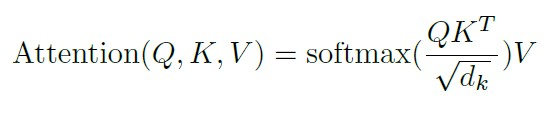

In [23]:
Image(filename='../other/attention_equation.jpg', width=400)

The division by the square root of the model dimension is justified by:
*We suspect that for large model dimensions, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients. To counteract this effect, we scale the dot products by 1/sqrt(model_dimension)*

**MASKING**

One thing missing from the formula is the mask that is applied before softmax inside the attention mechanism. When applied, the mask sets all values that correspond to **unwanted connections to minus infinity**. 

There are two types used: 
- Padding mask
- Lookahead mask. 

Padding mask prevents the attention mechanism inside the encoder to pay attention to padding tokens. Lookahead mask, used in the decoder, additionally prevents attending to positions over the current position.

When implemented in code it looks like this:

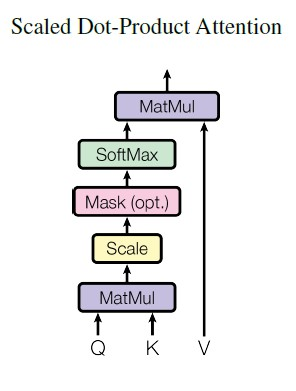

In [24]:
Image(filename='../other/scaled_dot_product_attention.jpg')

In [25]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super(ScaledDotProductAttention, self).__init__()

        self.d_head = d_head

        # Optional dropout (not mentioned in the paper)
        self.attention_dropout = nn.Dropout(p=0.1)

    def forward(self, q, k, v, mask=None):
        # q, k, v dims: (batch_size, n_heads, seq_len, d_head)

        attention_weights = torch.matmul(q, k.transpose(-2, -1))  # (batch_size, n_heads, seq_len, seq_len)
        scaled_attention_weights = attention_weights / math.sqrt(self.d_head)  # (batch_size, n_heads, seq_len, seq_len)

        if mask is not None:
            scaled_attention_weights = scaled_attention_weights.masked_fill(mask == 0, float('-inf')) # (batch_size, n_heads, seq_len, seq_len)

        # Apply softmax over the last dimension which corresponds to attention weights for a key 
        scaled_attention_weights = nn.functional.softmax(scaled_attention_weights, dim=-1) # (batch_size, n_heads, seq_len, seq_len)

        # Optional dropout (not mentioned in the paper)
        scaled_attention_weights = self.attention_dropout(scaled_attention_weights) # (batch_size, n_heads, seq_len, seq_len)

        weighted_v = torch.matmul(scaled_attention_weights, v) # (batch_size, n_heads, seq_len, d_head)

        return weighted_v

### Multi Head Attention



It was found beneficial to **project input to different *Q*s, *K*s and *V*s *n_head* times**. This way each head projects to a smaller dimension equal to *d_model / d_head* in order to keep the computational complexity the same. Intuitively this enables the network to ask more questions with different queries. In other words it gives multiple representation subspaces. It can also be thought of as a for loop over the attention mechanism. Also notice an additional linear layer *W0*

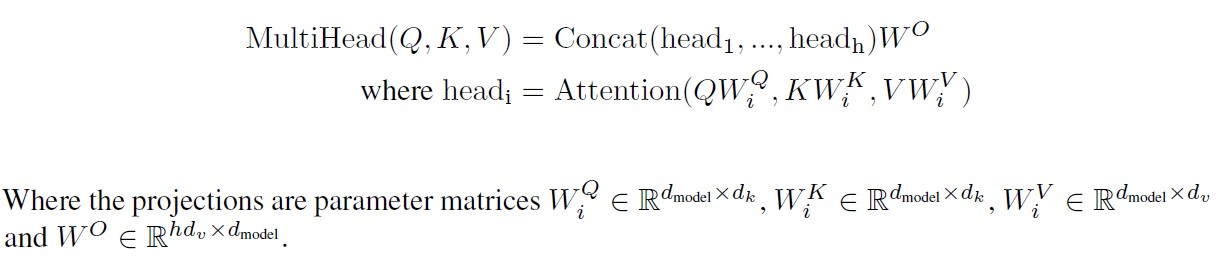

In [26]:
Image(filename='../other/multihead_attention_equation.jpg', width=800)

Visualized it looks like this:


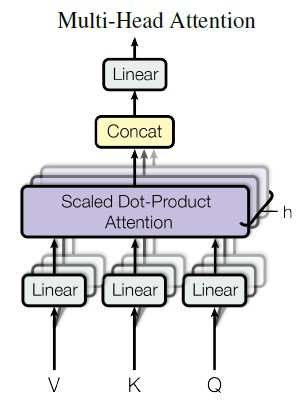

In [27]:
Image(filename='../other/multihead_attention.jpg', width=300)

Multi head attention can also be parallelized since no one head's value depends on the value of any other head.


In [28]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()

        self.n_heads= n_heads

        assert d_model % n_heads == 0
        self.d_head = d_model // n_heads

        self.dot_product_attention_layer= ScaledDotProductAttention(self.d_head)

        self.W_0 = nn.Linear(d_model, d_model)

    def _split_into_heads(self, q,k,v):
        q= q.view(q.size(0), q.size(1), self.n_heads, self.d_head) # (batch_size, seq_len, n_heads, d_head)
        k= k.view(k.size(0), k.size(1), self.n_heads, self.d_head) # (batch_size, seq_len, n_heads, d_head)
        v= v.view(v.size(0), v.size(1), self.n_heads, self.d_head) # (batch_size, seq_len, n_heads, d_head)

        q= q.transpose(1,2) # (batch_size, n_heads, seq_len, d_head)
        k= k.transpose(1,2) # (batch_size, n_heads, seq_len, d_head)
        v= v.transpose(1,2) # (batch_size, n_heads, seq_len, d_head)

        return q,k,v

    def _concatenate_heads(self,attention_output):
        attention_output = attention_output.transpose(1,2).contiguous() # (batch_size, seq_len, n_heads, d_head)
        attention_output = attention_output.view(attention_output.size(0), attention_output.size(1), -1) # (batch_size, seq_len, n_heads * d_head)

        return attention_output

    def forward(self, q, k, v, mask=None):
        q,k,v= self._split_into_heads(q,k,v) # (batch_size, n_heads, seq_len, d_head)
        attention_output = self.dot_product_attention_layer(q, k, v, mask) # (batch_size, n_heads, seq_len, d_head)
        attention_output = self._concatenate_heads(attention_output) # (batch_size, seq_len, n_heads * d_head)

        attention_output = self.W_0(attention_output) # (batch_size, seq_len, d_model)

        return attention_output 


##  Transformer Encoder Block
Encoder's job is to **process the source sequence and output it's word embeddings fused with attention representation & positional encoding for use in the decoder**. 

The encoder blocks are **stacked *N* times** each feeding its output to the next one's input (word embedding and positional encoding layers are only applied before the first encoder block)


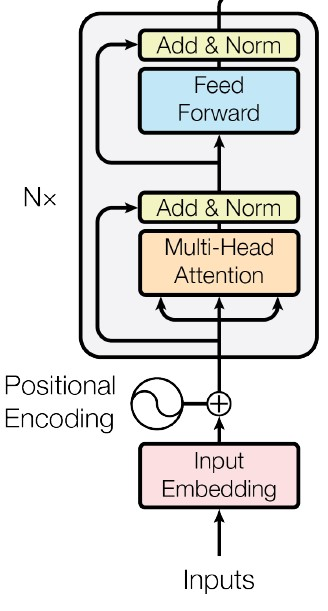

In [29]:
Image(filename='../other/encoder.jpg', width=250)

**Note:** Only the output of the last encoder block will ever be considered by the decoder.

Additional implementation details include:
- Dropout is applied to the output of each sub-layer, before it is added to the
sub-layer input and normalized.

In [30]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout_proba):
        super(TransformerEncoderBlock, self).__init__()

        self.W_q = nn.Linear(d_model, d_model) 
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        self.mha_layer=MultiHeadAttention(d_model, n_heads)
        self.dropout_layer_1=nn.Dropout(dropout_proba)
        self.add_and_norm_layer_1 = AddAndNorm(d_model)

        self.ffn_layer = PositionWiseFeedForwardNet(d_model, d_ff)
        self.dropout_layer_2=nn.Dropout(dropout_proba)
        self.add_and_norm_layer_2 = AddAndNorm(d_model)

    def forward(self, x, mask):
        # x dims: (batch_size, src_seq_len, d_model)
        # mask dim: (batch_size, 1, 1, src_seq_len)

        q = self.W_q(x) # (batch_size, src_seq_len, d_model)
        k = self.W_k(x) # (batch_size, src_seq_len, d_model)
        v = self.W_v(x) # (batch_size, src_seq_len, d_model)

        mha_out = self.mha_layer(q, k, v, mask) # (batch_size, src_seq_len, d_model)
        mha_out= self.dropout_layer_1(mha_out) # (batch_size, src_seq_len, d_model)
        mha_out = self.add_and_norm_layer_1(x, mha_out) # (batch_size, src_seq_len, d_model)

        ffn_out = self.ffn_layer(mha_out) # (batch_size, src_seq_len, d_model)
        ffn_out= self.dropout_layer_2(ffn_out) # (batch_size, src_seq_len, d_model)
        ffn_out = self.add_and_norm_layer_2(mha_out, ffn_out)  # (batch_size, src_seq_len, d_model)

        return ffn_out

## Transformer Encoder

In [31]:
class TransformerEncoder(nn.Module):
    def __init__(self, n_blocks, n_heads, d_model, d_ff, dropout_proba=0.1):
        super(TransformerEncoder, self).__init__()

        self.encoder_blocks=nn.ModuleList([TransformerEncoderBlock(d_model, n_heads, d_ff, dropout_proba) for _ in range(n_blocks)])

    def forward(self, x, mask):
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x, mask)
        return x

## Transformer Decoder Block
Decoder's job is to **process the target sequence with consideraton to the encoder output and output it's word embeddings fused with attention representation & positional encoding for predicting the next token**.

The decoder block is also repeated N times but unlike the encoder it has an **additional attention layer**. This layer is the **Encoder-Decoder attention** layer which **pulls context from the last encoder block's output** at each decoder step, helping it to decode.

During training the decoder predictions can be parallelized because we have the target tokens which we use in a teacher-forcing manner, but inference is done in an autoregressive manner.

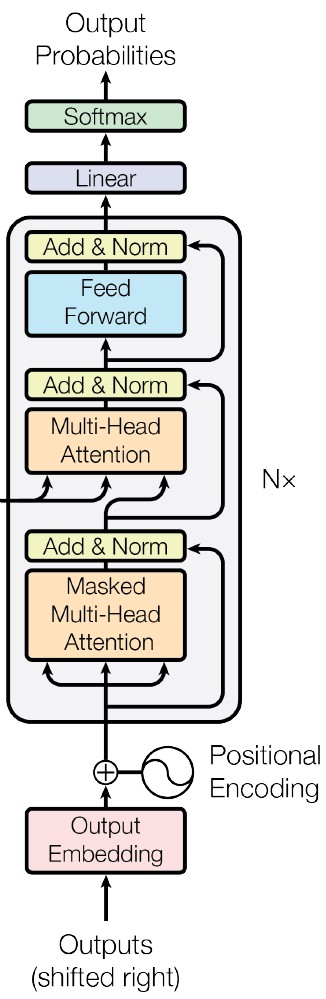

In [32]:
Image(filename='../other/decoder.jpg', width=250)

Additional implementation details include:
- Dropout is applied to the output of each sub-layer, before it is added to the
sub-layer input and normalized.

In [33]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout_proba):
        super(TransformerDecoderBlock, self).__init__()

        self.W_q_1 = nn.Linear(d_model, d_model)
        self.W_k_1 = nn.Linear(d_model, d_model)
        self.W_v_1 = nn.Linear(d_model, d_model)

        self.mha_layer_1=MultiHeadAttention(d_model, n_heads)
        self.dropout_layer_1=nn.Dropout(dropout_proba)
        self.add_and_norm_1 = AddAndNorm(d_model)

        self.W_q_2 = nn.Linear(d_model, d_model)
        self.W_k_2 = nn.Linear(d_model, d_model)
        self.W_v_2 = nn.Linear(d_model, d_model)

        self.mha_layer_2=MultiHeadAttention(d_model, n_heads)
        self.dropout_layer_2=nn.Dropout(dropout_proba)
        self.add_and_norm_2 = AddAndNorm(d_model)

        self.ffn_layer = PositionWiseFeedForwardNet(d_model, d_ff)
        self.dropout_layer_3=nn.Dropout(dropout_proba)
        self.add_and_norm_3 = AddAndNorm(d_model)

    def forward(self, x, encoder_output, src_mask, trg_mask):
        # x dims: (batch_size, trg_seq_len, d_model)
        # encoder_output dims: (batch_size, src_seq_len, d_model)
        # src_mask dim: (batch_size, 1, 1, src_seq_len)
        # trg_mask dim: (batch_size, 1, trg_seq_len, trg_seq_len)

        # 1st attention layer, trg_mask is used here
        q_1 = self.W_q_1(x) # (batch_size, trg_seq_len, d_model)
        k_1 = self.W_k_1(x) # (batch_size, trg_seq_len, d_model)
        v_1 = self.W_v_1(x) # (batch_size, trg_seq_len, d_model)

        mha_layer_1_out = self.mha_layer_1(q_1, k_1, v_1, trg_mask) # (batch_size, trg_seq_len, d_model)
        mha_layer_1_out= self.dropout_layer_1(mha_layer_1_out) # (batch_size, trg_seq_len, d_model)
        mha_layer_1_out = self.add_and_norm_1(mha_layer_1_out, x) # (batch_size, trg_seq_len, d_model)

        # 2nd attention layer, src_mask is used here
        q_2 = self.W_q_2(mha_layer_1_out) # (batch_size, trg_seq_len, d_model)
        k_2 = self.W_k_2(encoder_output) # (batch_size, src_seq_len, d_model)
        v_2 = self.W_v_2(encoder_output) # (batch_size, src_seq_len, d_model)

        mha_layer_2_out = self.mha_layer_2(q_2, k_2, v_2, src_mask) # (batch_size, trg_seq_len, d_model)
        mha_layer_2_out= self.dropout_layer_2(mha_layer_2_out) # (batch_size, trg_seq_len, d_model)
        mha_layer_2_out = self.add_and_norm_2(mha_layer_2_out, mha_layer_1_out) # (batch_size, trg_seq_len, d_model)

        # Position-wise feed forward
        ffn_out = self.ffn_layer(mha_layer_2_out) # (batch_size, trg_seq_len, d_model)
        ffn_out= self.dropout_layer_3(ffn_out) # (batch_size, trg_seq_len, d_model)
        ffn_out = self.add_and_norm_3(ffn_out, mha_layer_2_out) # (batch_size, trg_seq_len, d_model)
        
        return ffn_out


## Transformer Decoder

In [34]:
class TransformerDecoder(nn.Module):
    def __init__(self, n_blocks, n_heads, d_model, d_ff, dropout_proba):
        super(TransformerDecoder, self).__init__()

        self.decoder_blocks=nn.ModuleList([TransformerDecoderBlock(d_model, n_heads, d_ff, dropout_proba) for _ in range(n_blocks)])

    def forward(self, x, encoder_output, src_mask, trg_mask):
        for decoder_block in self.decoder_blocks:
            x = decoder_block(x, encoder_output, src_mask, trg_mask)
        return x

## Full Encoder-Decoder Transformer

Encoder and decoder are connected in such a way that each decoder block can pull context from the decoder output.

Again, only the output of the last encoder block will ever be considered by the decoder which can be misleading looking at the visualization

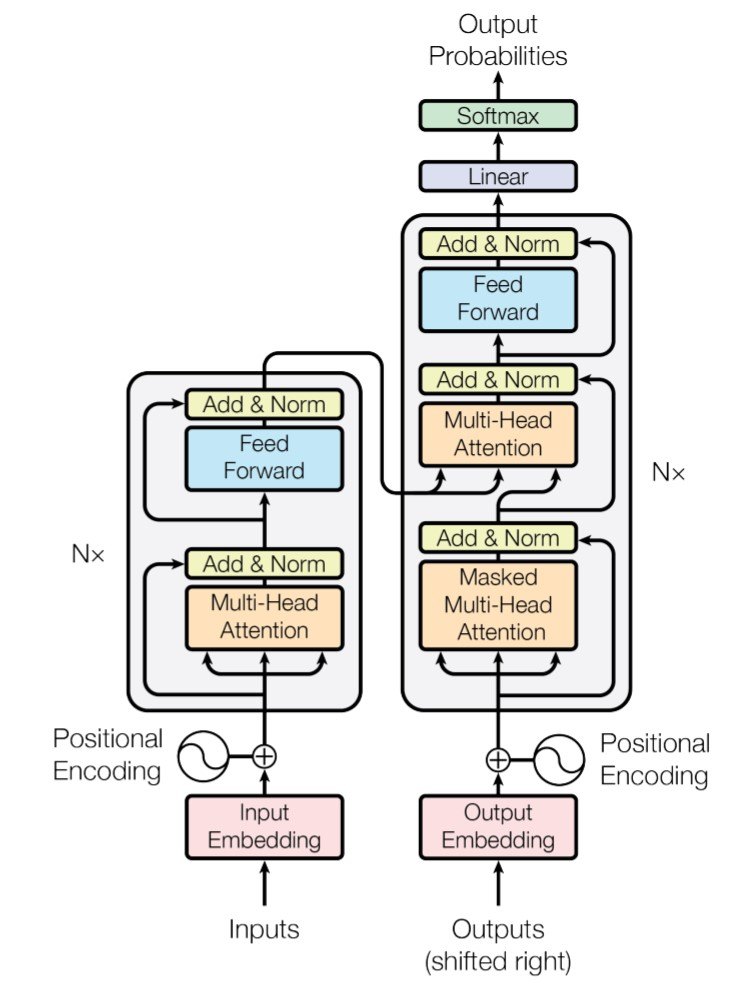

In [35]:
Image(filename='../other/transformer_architecture.jpg', width=500)

Additional implementation details include:
- Weights are shared between two embedding layers and the pre-softmax linear layer

In [36]:
class TransformerEncoderDecoder(nn.Module):
    def __init__(self,d_model, n_blocks, src_vocab_size, trg_vocab_size, n_heads, d_ff, dropout_proba):
        super(TransformerEncoderDecoder, self).__init__()
        self.dropout_proba = dropout_proba
        self.d_model=d_model

        # Encoder part
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.src_pos_embedding= PositionalEncoding(d_model)
        self.encoder= TransformerEncoder(n_blocks, n_heads, d_model, d_ff, dropout_proba)

        # Decoder part 
        self.trg_embedding = nn.Embedding(trg_vocab_size, d_model)
        self.trg_pos_embedding= PositionalEncoding(d_model)
        self.decoder= TransformerDecoder(n_blocks, n_heads, d_model, d_ff, dropout_proba)

        # Linear mapping to vocab size
        self.linear = nn.Linear(d_model, trg_vocab_size)

        # Switch to xavier initialization (shown to be beneficial)
        self.init_with_xavier()

        # Sharing weights between two embedding layers and the pre-softmax linear layer
        self.src_embedding.weight = self.trg_embedding.weight
        self.linear.weight = self.trg_embedding.weight

    def encode(self, src_token_ids, src_mask):
        # Encoder part
        src_embeddings = self.src_embedding(src_token_ids) * math.sqrt(self.d_model) # (batch_size, src_seq_len, d_model)
        src_embeddings = self.src_pos_embedding(src_embeddings) # (batch_size, src_seq_len, d_model)
        encoder_outputs = self.encoder(src_embeddings, src_mask) # (batch_size, src_seq_len, d_model)  

        return encoder_outputs

    def decode(self, trg_token_ids, encoder_outputs, src_mask, trg_mask):
        # Decoder part
        trg_embeddings = self.trg_embedding(trg_token_ids) * math.sqrt(self.d_model) # (batch_size, trg_seq_len, d_model)
        trg_embeddings = self.trg_pos_embedding(trg_embeddings) # (batch_size, trg_seq_len, d_model)
        decoder_outputs = self.decoder(trg_embeddings, encoder_outputs, src_mask, trg_mask) # (batch_size, trg_seq_len, d_model)

        # Linear mapping to vocab size
        linear_out = self.linear(decoder_outputs) # (batch_size, trg_seq_len, trg_vocab_size)

        return linear_out

    def forward(self, src_token_ids, trg_token_ids, src_mask, trg_mask):

        encoder_outputs= self.encode(src_token_ids, src_mask) # (batch_size, src_seq_len, d_model)
        decoder_outputs= self.decode(trg_token_ids, encoder_outputs, src_mask, trg_mask) # (batch_size, trg_seq_len, d_model)

        return decoder_outputs 

    def init_with_xavier(self):
        for name, p in self.named_parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

# Wrap the Transformer into a Machine Translation Transformer
Once we have the transformer architecture we need to take care of some "preprocessing" and "postprocessing" details related to it's use. That is why we will wrap it into MachineTranslationTransformer class which will additionally handle the following:
- Creating pad mask.
- Creating lookahead mask.
- Sentence tokenization with the aid of a tokenizer and input preparation.
- Autoregressive decoding for inference (greedy decoding used). 


In [37]:
class MachineTranslationTransformer(nn.Module):
    def __init__(self, d_model,n_blocks,src_vocab_size,trg_vocab_size,n_heads,d_ff, dropout_proba):
        super(MachineTranslationTransformer, self).__init__()

        self.transformer_encoder_decoder=TransformerEncoderDecoder(
            d_model,
            n_blocks,
            src_vocab_size,
            trg_vocab_size,
            n_heads,
            d_ff,
            dropout_proba
        )

    def _get_pad_mask(self, token_ids, pad_idx=0):
        pad_mask= (token_ids != pad_idx).unsqueeze(-2) # (batch_size, 1, seq_len)
        return pad_mask.unsqueeze(1)

    def _get_lookahead_mask(self, token_ids):
        sz_b, len_s = token_ids.size()
        subsequent_mask = (1 - torch.triu(torch.ones((1, len_s, len_s), device=token_ids.device), diagonal=1)).bool()
        return subsequent_mask.unsqueeze(1)

    def forward(self, src_token_ids, trg_token_ids):

        # Since trg_token_ids contains both [BOS] and [SOS] tokens
        # we need to remove the [EOS] token when using it as input to the decoder.
        # Similarly we remove the [BOS] token when we use it as y to calculate loss,
        # which also makes y and y_pred shapes match.

        # Removing [EOS] token
        trg_token_ids=trg_token_ids[:, :-1]

        src_mask = self._get_pad_mask(src_token_ids) # (batch_size, 1, 1, src_seq_len)
        trg_mask = self._get_pad_mask(trg_token_ids) & self._get_lookahead_mask(trg_token_ids)  # (batch_size, 1, trg_seq_len, trg_seq_len)

        return self.transformer_encoder_decoder(src_token_ids, trg_token_ids, src_mask, trg_mask)

    def preprocess(self, sentence, tokenizer):
        device = next(self.parameters()).device

        src_token_ids=tokenizer.encode(sentence).ids
        src_token_ids=torch.tensor(src_token_ids, dtype=torch.long).to(device)
        src_token_ids=src_token_ids.unsqueeze(0) # To batch format

        return src_token_ids

    def translate(self, sentence, tokenizer, max_tokens=100, skip_special_tokens=False):

        # Infer the device of the model
        device = next(self.parameters()).device

        # Get tokenizer special tokens.
        eos_id=tokenizer.token_to_id('[EOS]')
        bos_id=tokenizer.token_to_id('[BOS]')
        pad_id = tokenizer.token_to_id('[PAD]')

        # Tokenize sentence. 
        src_token_ids=self.preprocess(sentence, tokenizer)

        # Initialize target sequence with SOS token.
        trg_token_ids=torch.LongTensor([bos_id]).unsqueeze(0).to(device) # (1, 1)

        # Obtain src mask 
        src_mask=self._get_pad_mask(src_token_ids) # (batch_size, src_seq_len)

        # with torch.no_grad():
        encoder_output=self.transformer_encoder_decoder.encode(src_token_ids, src_mask) # (batch_size, src_seq_len, d_model)

        while True:

            # Obtain decoder output.
            trg_mask=self._get_lookahead_mask(trg_token_ids)  # Can also be set to None but for my config I found this works better.
            decoder_output=self.transformer_encoder_decoder.decode(trg_token_ids, encoder_output, src_mask, trg_mask)

            # Identify token with highest probability.
            softmax_output=nn.functional.log_softmax(decoder_output, dim=-1) # (batch_size, trg_seq_len, trg_vocab_size)
            softmax_output_last=softmax_output[:, -1, :] # (batch_size, trg_vocab_size)
            _, token_id=softmax_output_last.max(dim=-1) # (batch_size, trg_seq_len)

            # Check if token is EOS or we reached the maximum number of tokens.
            if token_id.item() == eos_id or trg_token_ids.size(1) == max_tokens:
                trg_token_ids=torch.cat([trg_token_ids, token_id.unsqueeze(0)], dim=-1) # (batch_size, trg_seq_len+1)
                break

            # Add token to target sequence.
            trg_token_ids=torch.cat([trg_token_ids, token_id.unsqueeze(0)], dim=-1) # (batch_size, trg_seq_len+1)

        # Detokenize sentence.
        decoded_output=tokenizer.decode(trg_token_ids.squeeze(0).detach().cpu().numpy(), skip_special_tokens=skip_special_tokens)

        return decoded_output

# Training Loop

## Define a Custom Scheduler

Authors used a custom scheduler when training: 

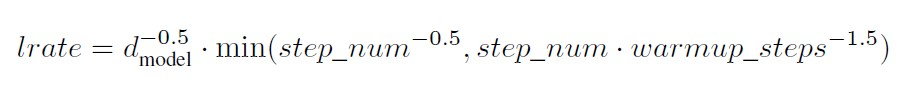

In [38]:
Image(filename='../other/scheduler_equation.jpg', width=700)

*This corresponds to increasing the learning rate linearly for the first warmup_steps training steps,
and decreasing it thereafter proportionally to the inverse square root of the step number*

In [39]:
class CustomScheduler():

    def __init__(self, optimizer, d_model, n_warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.cur_step = 0
        self.cur_lr=None

        # Init LR right away
        self.step()

    def step(self):
        self.cur_step += 1
        self.cur_lr=self._get_lr()

        for p in self.optimizer.param_groups:
            p['lr'] = self.cur_lr

    def _get_lr(self):
        return self.d_model**(-0.5) * min(self.cur_step**(-0.5), self.cur_step*self.n_warmup_steps**(-1.5))

    def get_last_lr(self):
        return [group['lr'] for group in self.optimizer.param_groups]

    def zero_grad(self):
        self.optimizer.zero_grad()

## Initialize Training Configuration

In [ ]:
model = MachineTranslationTransformer(
    d_model=config['D_MODEL'],
    n_blocks=config['N_BLOCKS'],
    src_vocab_size=config['VOCAB_SIZE'],
    trg_vocab_size=config['VOCAB_SIZE'],
    n_heads=config['N_HEADS'],
    d_ff=config['D_FF'],
    dropout_proba=config['DROPOUT_PROBA']
)

In [ ]:
loss_func = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=config['LABEL_SMOOTHING'], reduction='mean')
optimizer = optim.Adam(model.parameters(), betas=config['BETAS'], eps=config['EPS'])
scheduler=CustomScheduler(optimizer, config['D_MODEL'], config['N_WARMUP_STEPS'])

In [ ]:
if config['DEVICE']=='gpu':
    device='cuda'
else:
    device='cpu'

## Training loop

**Note:** This is a much simpler training loop then the one I implemented in src/learner.py. This training loop logs only training and validation loss. For training I highly suggest using the full source code

In [ ]:
import torch
torch.manual_seed(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)

cur_step=1
model.to(device)
for epoch_idx in range(config['EPOCHS']):
    
    # Train
    train_loss=0
    model.train()
    for batch_idx, batch in enumerate(train_dl):
        xb,yb=batch
        xb,yb =xb.to(device),yb.to(device)
        preds=model(xb,yb)
        
        loss=loss_func(
            preds.reshape(-1, preds.size(-1)), # Reshaping for loss
            yb[:,1:].contiguous().view(-1) # Shifting right (without BOS)
        )
        train_loss+=loss.detach().cpu()
        
        
        loss.backward()   
        if cur_step % config['GRAD_ACCUMULATION_STEPS']==0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            cur_step+=1
        
    # Validation
    val_loss=0
    with torch.no_grad():
        model.eval()
        for batch_idx, batch in enumerate(val_dl):
            xb,yb=batch
            xb,yb =xb.to(device),yb.to(device)
            preds=model(xb,yb)

            loss=loss_func(
                preds.reshape(-1, preds.size(-1)), # Reshaping for loss
                yb[:,1:].contiguous().view(-1) # Shifting right (without BOS)
            )
            val_loss+=loss.detach().cpu()
            
    print(f"Train Loss: {train_loss}, Validation Loss: {val_loss}")
            
            

# Inference

In [ ]:
input_sentence='Hello how are you'

In [ ]:
model.translate(input_sentence, tokenizer)